<a href="https://colab.research.google.com/github/voronv27/Lab1/blob/main/02_modeling_and_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(Load in data, set up week 1 data split, preprocessing, and model)

In [2]:
# open data file
import pandas as pd

path = 'Exam_Score_Prediction.csv'

data = pd.read_csv(path)
data.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [3]:
# Week 1 model
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

# separate features (x) from label (y)
label_col = "exam_score"
assert label_col in data.columns, f"Label column {label_col} not in data"

x = data.drop(columns=[label_col])
y = data[label_col]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

num_cols = [c for c in x_train.columns if x_train[c].dtype != 'object']
cat_cols = [c for c in x_train.columns if x_train[c].dtype == 'object']

# no missing values --> no need for imputer
numeric_tf = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ]
)

model_ridge = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", Ridge(alpha=1.0))
])

model_ridge.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['student_id', 'age',
                                                   'study_hours',
                                                   'class_attendance',
                                                   'sleep_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'course',
                                                   'internet_access',
                                                   'sleep_quality',
                                                   'study_method',
                                                   'facility_rating',
                                                   'exam_difficulty'])])),
                ('clf', Ridge())])

#Checkpoint C

##Train SVM Model

We will use LinearSVR for our SVM-family model.

In [4]:
from sklearn.svm import LinearSVR

model_svm = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LinearSVR(C=1, random_state=42))
])

model_svm.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['student_id', 'age',
                                                   'study_hours',
                                                   'class_attendance',
                                                   'sleep_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'course',
                                                   'internet_access',
                                                   'sleep_quality',
                                                   'study_method',
                                                   'facility_rating',
                                                   'exam_difficulty'])])),
                ('clf', LinearSVR(C=1, random_state=42))])

##Light Tuning

We will then use 3-fold CV to tune C for a few different settings in our model, comparing the MAE value (our chosen comparison metric from week 1) for the different settings.

In [5]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import numpy as np

for c in [0.1, 1, 5]:
  model_svm = Pipeline(steps=[
      ("preprocess", preprocess),
      ("clf", LinearSVR(C=c, random_state=42))
  ])

  model_svm.fit(x_train, y_train)

  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
  n_scores = cross_val_score(model_svm, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

  print(f'MAE (C={c}): {-np.mean(n_scores):.3f} ({np.std(n_scores):.3f})')


MAE (C=0.1): 7.869 (0.074)
MAE (C=1): 7.865 (0.076)
MAE (C=5): 7.866 (0.077)


The lowest MAE was for C=1, so we will use C=1 for our SVM model.

In [6]:
model_svm = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LinearSVR(C=1, random_state=42))
])

model_svm.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['student_id', 'age',
                                                   'study_hours',
                                                   'class_attendance',
                                                   'sleep_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'course',
                                                   'internet_access',
                                                   'sleep_quality',
                                                   'study_method',
                                                   'facility_rating',
                                                   'exam_difficulty'])])),
                ('clf', LinearSVR(C=1, random_state=42))])

##Compare to Week 1 Model

We will compare this model to our week 1 model (loaded above) on the same split and preprocessing. The metric we will use is MAE (Mean Absolute Error) as this is the metric we chose as our primary metric in week 1.

In [7]:
from sklearn.metrics import mean_absolute_error

y_pred = model_ridge.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE (Week 1--Ridge): {mae:.3f}")

y_pred = model_svm.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE (Week 2--SVR): {mae:.3f}")

MAE (Week 1--Ridge): 7.863
MAE (Week 2--SVR): 7.859


The MAE was slightly lower for week 2 with our SVR model, so this model is slightly better at predicting exam scores (by our chosen comparison metric).

##Experiment Log

Data Split and Preprocessing:

We split and preprocess the data as shown below. We do an 80/20 split with fixed seed 42.

In [8]:
from datetime import datetime
from zoneinfo import ZoneInfo

label_col = "exam_score"
assert label_col in data.columns, f"Label column {label_col} not in data"

x = data.drop(columns=[label_col])
y = data[label_col]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

num_cols = [c for c in x_train.columns if x_train[c].dtype != 'object']
cat_cols = [c for c in x_train.columns if x_train[c].dtype == 'object']

# no missing values --> no need for imputer
numeric_tf = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ]
)

timestamp = datetime.now(ZoneInfo('America/New_York')).strftime("%Y-%m-%d %H:%M:%S")
print("Timestamp (EST):", timestamp)

Timestamp (EST): 2026-02-11 17:52:21


Our comparison metric is MAE (Mean Absolute Error).

Our Ridge Regression model sets the hyperparameter alpha=1.0. It likely doesn't affect the model (since random_state doesn't matter to Ridge for most solvers) but we fix random_state to 42 for this model.

In [9]:
model_ridge = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", Ridge(alpha=1.0, random_state=42))
])

model_ridge.fit(x_train, y_train)

y_pred = model_ridge.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE (Week 1--Ridge): {mae:.3f}")

timestamp = datetime.now(ZoneInfo('America/New_York')).strftime("%Y-%m-%d %H:%M:%S")
print("Timestamp (EST):", timestamp)

MAE (Week 1--Ridge): 7.863
Timestamp (EST): 2026-02-11 17:52:21


The SVR models we tested have C values of 0.1, 1, and 5. We set the seed (random_state) to 42.

In [10]:
for c in [0.1, 1, 5]:
  model_svm = Pipeline(steps=[
      ("preprocess", preprocess),
      ("clf", LinearSVR(C=c, random_state=42))
  ])

  model_svm.fit(x_train, y_train)
  y_pred = model_svm.predict(x_test)
  mae = mean_absolute_error(y_test, y_pred)
  print(f"MAE (Week 2--SVR, C={c}): {mae:.3f}")

  timestamp = datetime.now(ZoneInfo('America/New_York')).strftime("%Y-%m-%d %H:%M:%S")
  print("Timestamp (EST):", timestamp)
  print()


MAE (Week 2--SVR, C=0.1): 7.867
Timestamp (EST): 2026-02-11 17:52:22

MAE (Week 2--SVR, C=1): 7.859
Timestamp (EST): 2026-02-11 17:52:22

MAE (Week 2--SVR, C=5): 7.860
Timestamp (EST): 2026-02-11 17:52:22



We use the model with C=1 as it has the lowest MAE.

#Checkpoint D

We skip calibration as we are not doing a classification problem.

##Define Threshold

Since our problem is a regression problem and not a classification problem, we can't really define a threshold.

A threshold is used in classification problems to decide on what percent probability to assign a datapoint into class 0/1. For example, a threshold of 0.78 means that if the probability for a point being in class 1 is 0.5, it would be predicted as class 0.

However, our problem doesn't have classes, it predicts a continuous score from 0 to 100. A threshold value wouldn't represent anything--when our model predicts 78, it's not saying that there's a 78% chance of getting 100%, it's saying the predicted exam score is 78.

For the sake of this checkpoint, we redefined our problem into a classification problem by mapping our y column into 0/1 for pass ($\ge60$%) and fail ($<60$%).

In [11]:
data_new = data.copy(deep=True)
data_new['pass_fail'] = (data_new[label_col] > 60.0).astype(int)

data_new = data_new.drop(columns = label_col)

data_new.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,pass_fail
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,0
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,0
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,1
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,0
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,0


In [12]:
from datetime import datetime
from zoneinfo import ZoneInfo

label_col = "exam_score"
assert label_col in data.columns, f"Label column {label_col} not in data"

x = data_new.drop(columns=['pass_fail'])
y = data_new['pass_fail']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

num_cols = [c for c in x_train.columns if x_train[c].dtype != 'object']
cat_cols = [c for c in x_train.columns if x_train[c].dtype == 'object']

# no missing values --> no need for imputer
numeric_tf = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ]
)

timestamp = datetime.now(ZoneInfo('America/New_York')).strftime("%Y-%m-%d %H:%M:%S")
print("Timestamp (EST):", timestamp)

Timestamp (EST): 2026-02-11 17:52:22


In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

model_binary = Pipeline(steps=[
      ("preprocess", preprocess),
      ("clf", CalibratedClassifierCV(GaussianNB(), cv = 3))
  ])



model_binary.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['student_id', 'age',
                                                   'study_hours',
                                                   'class_attendance',
                                                   'sleep_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'course',
                                                   'internet_access',
                                                   'sleep_quality',
                                                   'study_method',
                                                   'facility_rating',
                                                   'exam_difficulty'])])),
                ('clf', CalibratedClassifierCV(cv=3, estimator=GaussianNB()))])

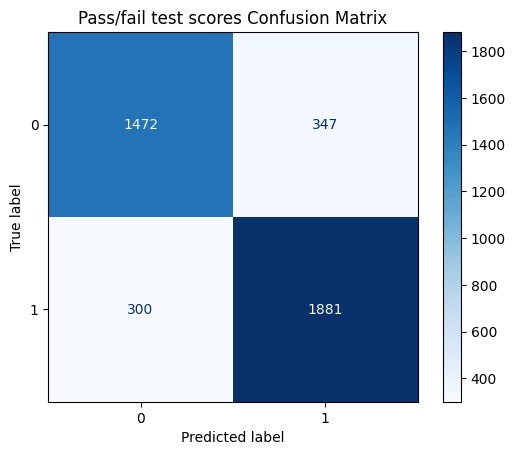

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model_binary.predict(x_test)

y_proba = model_binary.predict_proba(x_test)

y_pred = np.argmax(y_proba, axis=1)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_binary.classes_
                              )

disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Pass/fail test scores Confusion Matrix")
plt.show()

0.4


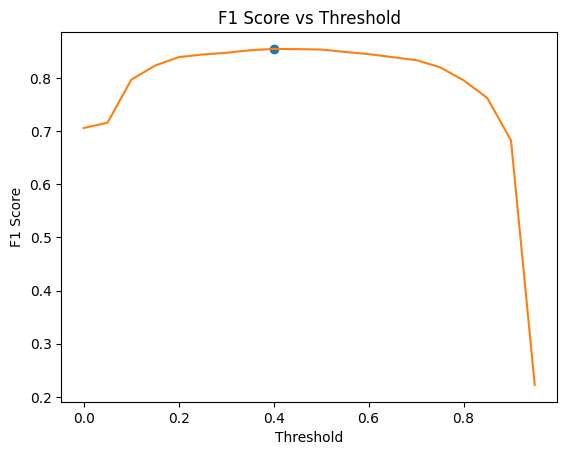

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score


def pred_at_threshold(y_proba, threshold):
  y_pred = (y_proba[:, 1] >= threshold).astype(int)
  return y_pred


threshold_scores = dict()

for n in range(0,20):
  threshold = 0.05*n
  y_pred = pred_at_threshold(y_proba, threshold)

  f1 = f1_score(y_test, y_pred)

  threshold_scores[threshold] = f1


res = max(threshold_scores, key = threshold_scores.get)

print(res)

plt.plot(res, threshold_scores[res], ' o')
plt.plot(list(threshold_scores.keys()), list(threshold_scores.values()))
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.show()




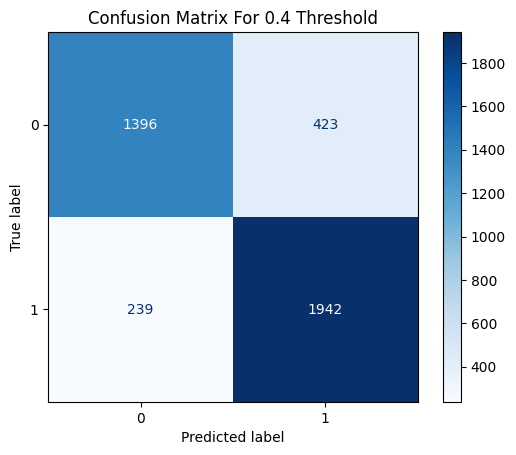

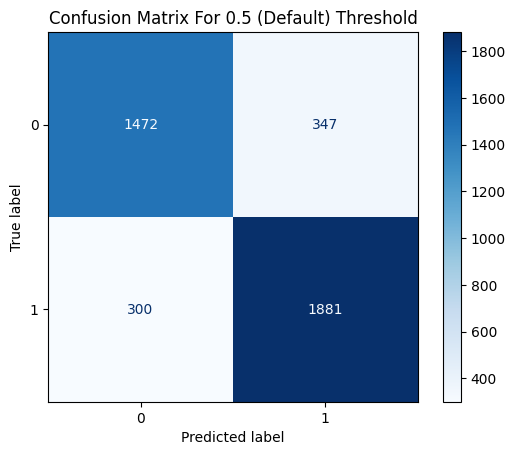

f1-score for 0.4 threshold: 0.854
f1-score for default 0.5 threshold: 0.853


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_best = pred_at_threshold(y_proba, res)
cm = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_binary.classes_
                              )

disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix For 0.4 Threshold")
plt.show()

y_pred_default = pred_at_threshold(y_proba, 0.5)
cm = confusion_matrix(y_test, y_pred_default)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_binary.classes_
                              )

disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix For 0.5 (Default) Threshold")
plt.show()

# comparing f1-scores
print(f"f1-score for 0.4 threshold: {f1_score(y_test, y_pred_best):.3f}")
print(f"f1-score for default 0.5 threshold: {f1_score(y_test, y_pred_default):.3f}")

This threshold of 0.4 has a better f1-score than the default, meaning that it has a better combined precision and recall. This means that it is less likely than the default threshold to predict false values (whether false positive or negative). Interestingly, in the confusion matrix, the default threshold actually has less combined FP+FN (647 vs 662), however by our chosen metric of f1-score it is considered worse.

We chose f1-score as our metric since it lets us optimize both precision and recall, and we wanted our model to minimize false predictions. However, by a different metric, a different threshold may actually be considered better. In practice, the chosen evaluation metric should depend on the situation--for example, in the case where a teacher is trying to find students likely to fail so they can get extra attention, false positives are much worse, as any student predicted to pass without extra help will not be provided the extra help. In the example situation, precision would be a better metric as decreasing false positives is the goal. Meanwhile, for our situation where the goal is to have less FP and FN, f1-score is a good evaluation metric.